<a href="https://colab.research.google.com/github/mlacasa/2BATMates/blob/main/integralsBAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Instal·lació del paquet mxnet
%%shell

pip install tlcpack-nightly-cu113 --pre -f https://tlcpack.ai/wheels

Looking in links: https://tlcpack.ai/wheels


In [15]:
%%shell
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.7 MB/s eta 0:00:00


In [16]:
# comprobem ok
import mxnet as mx
print(mx.__version__)


1.9.1


In [ ]:
#Instal·lació llibreria d2l
!pip install d2l==1.0.3


# Càlcul integral

La diferenciació només constitueix la meitat del contingut d'una educació de càlcul tradicional. L'altre pilar, la integració, comença semblant una pregunta més aviat inconjunta: "Quina és l'àrea sota aquesta corba?" Tot i que aparentment no té relació, la integració està estretament entrellaçada amb la diferenciació mitjançant el que es coneix com el *teorema fonamental del càlcul*.

A nivell d'aprenentatge automàtic que comentem en aquest llibre, no necessitarem una comprensió profunda de la integració. Tanmateix, oferirem una breu introducció per establir les bases per a qualsevol altra aplicació que ens trobarem més endavant.

## Interpretació geomètrica
Suposem que tenim una funció $f(x)$. Per simplificar, suposem que $f(x)$ no és negatiu (mai pren un valor inferior a zero). El que volem intentar entendre és: quina és l'àrea continguda entre $f(x)$ i l'eix $x$?


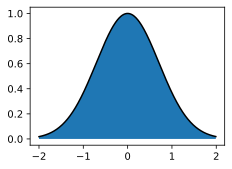

In [18]:
%matplotlib inline
from IPython import display
from mpl_toolkits import mplot3d
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

x = np.arange(-2, 2, 0.01)
f = np.exp(-x**2)

d2l.set_figsize()
d2l.plt.plot(x, f, color='black')
d2l.plt.fill_between(x.tolist(), f.tolist())
d2l.plt.show()

En la majoria dels casos, aquesta àrea serà infinita o no definida (considereu l'àrea sota $f(x) = x^{2}$), de manera que la gent sovint parlarà de l'àrea entre un parell d'extrems, per exemple $a$ i $ b$.


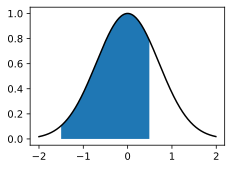

In [19]:
x = np.arange(-2, 2, 0.01)
f = np.exp(-x**2)

d2l.set_figsize()
d2l.plt.plot(x, f, color='black')
d2l.plt.fill_between(x.tolist()[50:250], f.tolist()[50:250])
d2l.plt.show()

Denotarem aquesta àrea amb el símbol integral següent:

$$
\textrm{Àrea}(\mathcal{A}) = \int_a^b f(x) \;dx.
$$

La variable interna és una variable simulada, molt semblant a l'índex d'una suma en un $\sum$, i així es pot escriure de manera equivalent amb qualsevol valor intern que ens agradi:

$$
\int_a^b f(x) \;dx = \int_a^b f(z) \;dz.
$$

Hi ha una manera tradicional d'intentar entendre com podríem intentar aproximar aquestes integrals: ens podem imaginar agafant la regió entre $a$ i $b$ i tallant-la en rodanxes verticals de $N$. Si $N$ és gran, podem aproximar l'àrea de cada porció amb un rectangle i després sumar les àrees per obtenir l'àrea total sota la corba. Fem una ullada a un exemple de fer-ho en codi. Veurem com obtenir el valor real en una secció posterior.


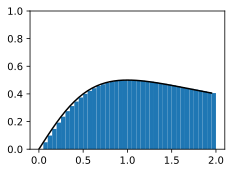

'approximation: 0.7944855690002441, truth: 0.34657359027997264'

In [20]:
epsilon = 0.05
a = 0
b = 2

x = np.arange(a, b, epsilon)
f = x / (1 + x**2)

approx = np.sum(epsilon*f)
true = np.log(2) / 2

d2l.set_figsize()
d2l.plt.bar(x.asnumpy(), f.asnumpy(), width=epsilon, align='edge')
d2l.plt.plot(x, f, color='black')
d2l.plt.ylim([0, 1])
d2l.plt.show()

f'approximation: {approx}, truth: {true}'

El problema és que, tot i que es pot fer numèricament, podem fer aquest enfocament analíticament només per a les funcions més senzilles com ara

$$
\int_a^b x \;dx.
$$

Qualsevol cosa una mica més complexa com el nostre exemple del codi anterior

$$
\int_a^b \frac{x}{1+x^{2}} \;dx.
$$

està més enllà del que podem resoldre amb un mètode tan directe.

En canvi, adoptarem un enfocament diferent. Treballarem de manera intuïtiva amb la noció d'àrea i coneixerem la principal eina computacional utilitzada per trobar integrals: el *teorema fonamental del càlcul*. Aquesta serà la base del nostre estudi d'integració.

## El teorema fonamental del càlcul

Per aprofundir en la teoria de la integració, introduïm una funció

$$
F(x) = \int_0^x f(y) dy.
$$

Aquesta funció mesura l'àrea entre $0$ i $x$ depenent de com canviem $x$. Tingueu en compte que això és tot el que necessitem des de llavors

$$
\int_a^b f(x) \;dx = F(b) - F(a).
$$

Aquesta és una codificació matemàtica del fet que podem mesurar l'àrea fins al punt final llunyà i després restar l'àrea al punt final proper.

![Visualitzant per què podem reduir el problema de calcular l'àrea sota una corba entre dos punts per calcular l'àrea a l'esquerra d'un punt.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/sub-area.svg?raw=1)


Així, podem esbrinar quina és la integral en qualsevol interval esbrinant què és $F(x)$.

Per fer-ho, considerem un experiment. Com fem sovint en càlcul, imaginem què passa quan canviem el valor una mica. Pel comentari anterior, ho sabem

$$
F(x+\epsilon) - F(x) = \int_x^{x+\epsilon} f(y) \; dy.
$$

Això ens indica que la funció canvia per l'àrea sota una petita part d'una funció.

Aquest és el punt en què fem una aproximació. Si mirem una petita part d'àrea com aquesta, sembla que aquesta àrea està a prop de l'àrea rectangular amb l'alçada del valor de $f(x)$ i l'amplada de la base $\epsilon$. De fet, es pot demostrar que a mesura que $\epsilon \rightarrow 0$ aquesta aproximació és millor i millor. Així podem concloure:

$$
F(x+\epsilon) - F(x) \approx \epsilon f(x).
$$

Tanmateix, ara podem notar: aquest és exactament el patró que esperem si calculéssim la derivada de $F$! Així veiem el següent fet força sorprenent:

$$
\frac{dF}{dx}(x) = f(x).
$$

Aquest és el *teorema fonamental del càlcul*. Ho podem escriure en forma ampliada com
$$\frac{d}{dx}\int_0^x f(y) \; dy = f(x).$$


Pren el concepte de trobar àrees (*a priori* més aviat difícil), i el redueix a un enunciat derivats (una cosa molt més ben entès). Un darrer comentari que hem de fer és que això no ens diu exactament què és $F(x)$. De fet, $F(x) + C$ per a qualsevol $C$ té la mateixa derivada. Aquest és un fet de la vida en la teoria de la integració. Afortunadament, observeu que quan es treballa amb integrals definides, les constants s'eliminen i, per tant, són irrellevants per al resultat.

$$
\int_a^b f(x) \; dx = (F(b) + C) - (F(a) + C) = F(b) - F(a).
$$

Això pot semblar un disbarat abstracte, però prenguem un moment per apreciar que ens ha donat una perspectiva completament nova sobre la computació d'integrals. El nostre objectiu ja no és fer algun tipus de procés de tall i suma per intentar recuperar l'àrea, sinó que només necessitem trobar una funció la derivada de la qual és la funció que tenim! Això és increïble, ja que ara podem enumerar moltes integrals força difícils. Per exemple, sabem que la derivada de $x^{n}$ és $nx^{n-1}$. Així, podem dir utilitzant el teorema fonamental

$$
\int_0^{x} ny^{n-1} \; dy = x^n - 0^n = x^n.
$$

De la mateixa manera, sabem que la derivada de $e^{x}$ és ella mateixa, de manera que això vol dir

$$
\int_0^{x} e^{x} \; dx = e^{x} - e^{0} = e^x - 1.
$$

D'aquesta manera, podem desenvolupar tota la teoria de la integració aprofitant les idees del càlcul diferencial lliurement. Tota regla d'integració deriva d'aquest fet.

## Canvi de variables

Igual que amb la diferenciació, hi ha una sèrie de regles que fan que el càlcul d'integrals sigui més manejable. De fet, cada regla de càlcul diferencial (com la regla del producte, la regla de la suma i la regla de la cadena) té una regla corresponent per al càlcul integral (integració per parts, linealitat d'integració i fórmula de canvi de variables, respectivament). En aquesta secció, ens endinsarem en el que sens dubte és el més important de la llista: la fórmula de canvi de variables.

Primer, suposem que tenim una funció que és en si mateixa una integral:

$$
F(x) = \int_0^x f(y) \; dy.
$$

Suposem que volem saber com es veu aquesta funció quan la composem amb una altra per obtenir $F(u(x))$. Per la regla de la cadena, ho sabem

$$
\frac{d}{dx}F(u(x)) = \frac{dF}{du}(u(x))\cdot \frac{du}{dx}.
$$

Podem convertir-ho en una afirmació sobre la integració utilitzant el teorema fonamental :eqref:`eq_ftc` com a anterior. Això dóna

$$
F(u(x)) - F(u(0)) = \int_0^x \frac{dF}{du}(u(y))\cdot \frac{du}{dy} \;dy.
$$

Si recordem que $F$ és en si mateix una integral, es pot reescriure el costat esquerre per ser

$$
\int_{u(0)}^{u(x)} f(y) \; dy = \int_0^x \frac{dF}{du}(u(y))\cdot \frac{du}{dy} \;dy.
$$

De la mateixa manera, recordar que $F$ és una integral ens permet reconèixer que $\frac{dF}{dx} = f$ utilitzant el teorema fonamental :eqref:`eq_ftc`, i per tant podem concloure

$$\int_{u(0)}^{u(x)} f(y) \; dy = \int_0^x f(u(y))\cdot \frac{du}{dy} \;dy.$$


Aquesta és la fórmula de *canvi de variables*.

Per a una derivació més intuïtiva, considereu què passa quan prenem una integral de $f(u(x))$ entre $x$ i $x+\epsilon$. Per a un $\epsilon$ petit, aquesta integral és aproximadament $\epsilon f(u(x))$, l'àrea del rectangle associat. Ara, comparem això amb la integral de $f(y)$ de $u(x)$ a $u(x+\epsilon)$. Sabem que $u(x+\epsilon) \approx u(x) + \epsilon \frac{du}{dx}(x)$, de manera que l'àrea d'aquest rectangle és aproximadament $\epsilon \frac{du}{dx }(x)f(u(x))$. Així, per fer que l'àrea d'aquests dos rectangles coincideixi, hem de multiplicar el primer per $\frac{du}{dx}(x)$.

![Visualització de la transformació d'un únic rectangle prim sota el canvi de variables.](https://raw.githubusercontent.com/d2l-ai/d2l-en-colab/master/img/rect-trans.svg)


Això ens diu que

$$
\int_x^{x+\epsilon} f(u(y))\frac{du}{dy}(y)\;dy = \int_{u(x)}^{u(x+\epsilon)} f(y ) \; dy.
$$

Aquesta és la fórmula de canvi de variables expressada per a un únic rectangle petit.

Si $u(x)$ i $f(x)$ es trien correctament, això pot permetre el càlcul d'integrals increïblement complexes. Per exemple, si fins i tot triem $f(y) = 1$ i $u(x) = e^{-x^{2}}$ (el que significa $\frac{du}{dx}(x) = - 2xe^{-x^{2}}$), això pot mostrar, per exemple, que

$$
e^{-1} - 1 = \int_{e^{-0}}^{e^{-1}} 1 \; dy = -2\int_0^{1} ye^{-y^2}\;dy,
$$

i així reordenant això

$$
\int_0^{1} tu^{-y^2}\; dy = \frac{1-e^{-1}}{2}.
$$

## Un comentari sobre les convencions de signes

Els lectors atents observaran alguna cosa estranya sobre els càlculs anteriors. És a dir, càlculs com

$$
\int_{e^{-0}}^{e^{-1}} 1 \; dy = e^{-1} -1 < 0,
$$

pot produir nombres negatius. Quan pensem en àrees, pot ser estrany veure un valor negatiu, i per tant val la pena investigar en què és la convenció.

Els matemàtics prenen la noció d'àrees signades. Això es manifesta de dues maneres. En primer lloc, si considerem una funció $f(x)$ que de vegades és menor que zero, llavors l'àrea també serà negativa. Així per exemple

$$
\int_0^{1} (-1)\;dx = -1.
$$

De la mateixa manera, les integrals que progressen de dreta a esquerra, en lloc d'esquerra a dreta, també es consideren àrees negatives

$$
\int_0^{-1} 1\; dx = -1.
$$

L'àrea estàndard (d'esquerra a dreta d'una funció positiva) és sempre positiva. Qualsevol cosa que s'obté en invertir-la (per exemple, girant l'eix $x$ per obtenir la integral d'un nombre negatiu, o girar l'eix $y$ per obtenir una integral en l'ordre incorrecte) produirà una àrea negativa. I, de fet, girar dues vegades donarà un parell de signes negatius que es cancel·len per tenir una àrea positiva

$$
\int_0^{-1} (-1)\;dx = 1.
$$

Si aquesta discussió li sembla familiar, ho és! A :numref:`sec_geometry-linear-algebraic-ops` vam discutir com el determinant representava l'àrea amb signe de la mateixa manera.



F(x) s'anomena una antiderivada o integral o primitiva de Newton-Leibnitz d'una funció f(x) en un interval I. F'(x) = f(x), per a cada valor de x en I.

La integral és la representació de l'àrea d'una regió sota una corba. Aproximem el valor real d'una integral dibuixant rectangles. Una integral definida d'una funció es pot representar com l'àrea de la regió limitada per la seva gràfica de la funció donada entre dos punts de la línia. L'àrea d'una regió es troba dividint-la en rectangles verticals prims i aplicant els límits inferior i superior, es resumeix l'àrea de la regió. Especifiquem una integral d'una funció en un interval en què es defineix la integral.

![](https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/integrals-1627571035.png)


## Integrals definides
Les integrals definides tenen un valor de límits preexistent, fent que el valor final d'una integral sigui definit. si f(x) és funció de la corba, aleshores


![](https://d138zd1ktt9iqe.cloudfront.net/media/seo_landing_files/definite-integral-1627571088.png)

In [47]:
# Càlcul d'intergrals
# Carreguem llibreries

from sympy import *
from sympy.abc import x, a, b, c
init_printing(use_latex="mathjax")

In [23]:
# definim amb f una funció qualsevol i executem amb integrate(f)
f = x**2 - 3*x + 2
integrate(f)

 3      2      
x    3⋅x       
── - ──── + 2⋅x
3     2        

In [32]:
f = log(exp(x))
f

   ⎛ x⎞
log⎝ℯ ⎠

In [33]:
integrate(f)

 2
x 
──
2 

In [44]:
f = (x * exp(asin(x)))/(sqrt(1-x**2))
f

    asin(x)
 x⋅ℯ       
───────────
   ________
  ╱      2 
╲╱  1 - x  

In [45]:
integrate(f)

                ________         
   asin(x)     ╱      2   asin(x)
x⋅ℯ          ╲╱  1 - x  ⋅ℯ       
────────── - ────────────────────
    2                 2          

In [48]:
f = a*x**2+b*x+c
integrate(f, x) # Avaluem la variable a integrar

   3      2      
a⋅x    b⋅x       
──── + ──── + c⋅x
 3      2        

In [50]:
f = a*log(x)
integrate(f, x)

a⋅x⋅log(x) - a⋅x

# Integrals definides

$\int_0^{\frac{\pi}{2}} \cos x \,\, dx$

In [52]:
f = cos(x)
integrate(f, (x, 0, pi/2.0))  # Observem que indica, la funció i els intervals

1

$\int_{-\infty}^{\infty} e^{-x^2} dx$

In [53]:
integrate(exp(-x**2), (x, -oo, oo)) # Observem com introduir infinits en sympy

√π